# Importing Dependencies

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Dense, Flatten,Lambda,Reshape,Dropout,BatchNormalization,Concatenate,ReLU
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Layer
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading datapoints

- $m$ - Observation at previous timestep $O_{t}$
- $a$ - Action label (3d vector)
- $p$ - Observation at next timestep $O_{t+1}$

Each file contains ~1000 datapoints

In [3]:
path_to_data_folder = "/content/drive/MyDrive/Thesis/plan Sai/Dataset/Dataset 2 - Different Values"
path_to_model = "/content/drive/MyDrive/Thesis/plan Sai/Models"
m = np.load(f'{path_to_data_folder}/m_ob0.npy')
a = np.load(f'{path_to_data_folder}/act0.npy')
p = np.load(f'{path_to_data_folder}/p_ob0.npy')

for i in range(1,123):
  # Progress Bar
  progress = i / 123;bar_length = 100;completed_length = int(bar_length * progress);bar = "Reading Data --> [" + "=" * completed_length + ">" + " " * (bar_length - completed_length) + "]";percentage = f"{progress * 100:.0f}%";sys.stdout.write(f"\r{bar} {percentage}");sys.stdout.flush()

  #Loading and concatnating each file
  m= np.concatenate((m,np.load(f'{path_to_data_folder}/m_ob{i}.npy')),axis = 0)
  a= np.concatenate((a,np.load(f'{path_to_data_folder}/act{i}.npy')),axis = 0)
  p= np.concatenate((p,np.load(f'{path_to_data_folder}/p_ob{i}.npy')),axis = 0)

Reading Data --> [===================================================================================================> ] 99%

# Data Preprocessing

In [4]:
#Clipping the values between 0 to 1
m[m > 1] = 1
p[p > 1] = 1
num_actions = 3

#Coupling m and a as a pair
m_with_action = np.column_stack((m,a))
m_dim = m.shape[1]
action_map = {0:"Straight",1:"Left",2:"Right"}


# Converting Numpy arrays to tensor datatype
m_t = tf.data.Dataset.from_tensor_slices(m_with_action)
p_t = tf.data.Dataset.from_tensor_slices(p)
dataset = tf.data.Dataset.zip((m_t, p_t))

def cast_to_new_dtype(element1, element2):return tf.dtypes.cast(element1, tf.float32), tf.dtypes.cast(element2, tf.float32)
dataset = dataset.map(cast_to_new_dtype)

print(f"Total Datapoints: {dataset.cardinality().numpy()}")
shuffled_dataset = dataset.shuffle(100)
dataset = shuffled_dataset.batch(2046)
print(f"Total Batches: {dataset.cardinality().numpy()}")

Total Datapoints: 130068
Total Batches: 64


# Helper Plot function

In [5]:
def plot(x,y,generated = [],generated_a = False):
  if len(generated) != 0: generated_a = True
  try:
    x = x.numpy().reshape(363,)
    y = y.numpy().reshape(360,)
    if generated_a:generated = generated.numpy();generated = generated.reshape(360,)
  except:pass
  munnadi = x[:360]
  pinnadi = y[:360]
  action__ = action_map[x[-3]]
  turn_angle = x[-2]
  velocity = x[-1]
  print(f"Action: {action__}, Turn Angle: {turn_angle}, Velocity: {velocity}")
  if generated_a: print(f"Deviation: {MeanSquaredError()(y,generated)}")
  fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
  ax1.plot(munnadi, label='Before')
  ax1.legend()
  ax1.set_yticks([])
  ax2.plot(pinnadi, label='After')
  if generated_a: ax2.plot(generated, label = "Generated")
  ax2.legend()
  ax2.set_yticks([])
  plt.subplots_adjust(hspace=0)
  plt.show()

# Ploting a sample datapoint

Action: Left, Turn Angle: 0.21666666865348816, Velocity: -1.0


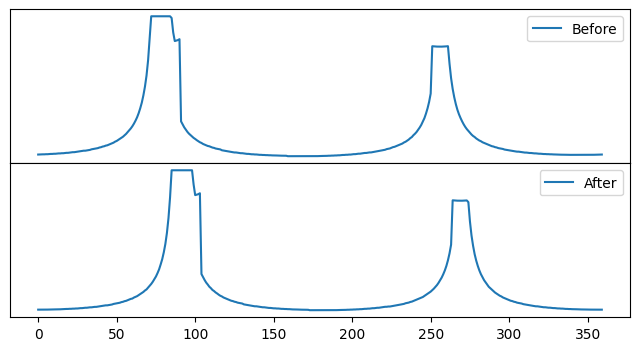

In [6]:
for x,y in dataset.take(1):plot(x[0],y[0])

# Building GAN...

`class NormalRandomLayer` - A sampling layer.

`class GAN` - Class with components of GAN
- &nbsp; `build_generator()` - Returns the Generator model (Encoder-Decoder Architecture)

- &nbsp; `generator_loss()` - **Args** - Discriminator Output (Real/Fake), Generator Output ( $Og_{t+1}$), Target Data ( $O_{t+1}$)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **To Do** -


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.   Compute Cross entropy loss between 1s and Discriminator Output

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.   Compute MSE between  $Og_{t+1}$ and $O_{t+1}$





&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Return** - Total Loss, Crossentopy Loss, Mean Square Loss, Weighted Loss

- &nbsp; `build_discriminator()` - Returns the Discriminator model

- &nbsp; `discriminator_loss()` - **Args** - Generator Output ( $Og_{t+1}$), Target Data ( $O_{t+1}$)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **To Do** - Compare the Generated data with 0 (*fake*) and Target Data with 1(*Real*)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Return** - Cross entropy Loss

- &nbsp; `compile()` - Compiles Both Generator and discriminator with Loss functions and Optimizer

- &nbsp; `visual_inspection()` - Samples a random data point from the batch and feed forwards through generator

- &nbsp; `execute()` - Excutes Custom action command on given Observation $O_{t}$ and returns the Generated  $Og_{t+1}$

`class Monitor` - Monitors the Performance at end of every `take_action_epoch` epoch


In [7]:
class NormalRandomLayer(Layer):
    def __init__(self, **kwargs):
        super(NormalRandomLayer, self).__init__(**kwargs)
        self.dimension = 512
    def call(self, inputs):
        shape = (tf.shape(inputs)[0], self.dimension)  # Use the batch size of the input
        random_numbers = tf.random.normal(shape)
        return random_numbers

class GAN(Model):
  def __init__(self,m_dim = 360, num_actions = 3, Load_model = False, **kwargs):
    super().__init__(**kwargs)
    self.m_dim = m_dim
    self.num_actions = num_actions
    self.sample_layer = True
    self.generator = self.build_generator()
    self.discriminator = self.build_discriminator()
    if Load_model:
      self.generator = load_model(f"{path_to_model}/Generator.h5")
      self.discriminator = load_model(f"{path_to_model}/Discriminator.h5")
    self.l1_lamda = 100
    self.action_map = {0:"Straight",1:"Left",2:"Right"}

  def build_generator(self):

    #________________________________________________________________Input Layer____________________________________________________________________
    input_layer = keras.Input(shape=(m_dim+num_actions,))
    # spliting the input layer to Observation and action
    split_layer = Lambda(lambda x: (x[:, :m_dim], x[:, m_dim:]))
    observation,action = split_layer(input_layer)

    action = Dense(16)(action)
    #________________________________________________________________Encoder____________________________________________________________________
    #Concatnating the action label with every layer of Encoder with a dropout and a ReLU layer
    e1 = Dense(256)(observation)
    e1 = Concatenate()([e1,action])
    e1 = Dropout(0.5)(e1)
    e1 = ReLU()(e1)

    e2 = Dense(128)(e1)
    e2 = Concatenate()([e2,action])
    e2 = Dropout(0.5)(e2)
    e2 = ReLU()(e2)


    e3 = Dense(64)(e2)
    e3 = Concatenate()([e3,action])
    e3 = Dropout(0.5)(e3)
    e3 = ReLU()(e3)

    e4 = Dense(32)(e3)
    e4 = Concatenate()([e4,action])
    e4 = Dropout(0.5)(e4)
    e4 = ReLU()(e4)
    #________________________________________________________________Latent____________________________________________________________________
    latent = Dense(16)(e4)

    if self.sample_layer:
      #Sampling from normal distribution
      sample = NormalRandomLayer()(observation)
      # Gate
      sample = Concatenate()([sample,latent])
      sample = Dense(256, activation = "sigmoid")(sample)
      latent = Concatenate()([latent,sample])
    #________________________________________________________________Decoder____________________________________________________________________
    #Concatnating the action label and encoder output with every layer of decoder with a dropout and a ReLU layer
    d4 =  Dense(32)(latent)
    d4 = Concatenate()([d4,e4])
    d4 = Concatenate()([d4,action])
    d4 = Dropout(0.5)(d4)
    d4 = ReLU()(d4)

    d3 =  Dense(64)(d4)
    d3 = Concatenate()([d3,e3])
    d3 = Concatenate()([d3,action])
    d3 = Dropout(0.5)(d3)
    d3 = ReLU()(d3)

    d2 =  Dense(128)(d3)
    d2 = Concatenate()([d2,e2])
    d2 = Concatenate()([d2,action])
    d2 = Dropout(0.5)(d2)
    d2 = ReLU()(d2)

    d1 =  Dense(256)(d2)
    d1 = Concatenate()([d1,e1])
    d1 = Concatenate()([d1,action])
    d1 = Dropout(0.5)(d1)
    d1 = ReLU()(d1)
    #________________________________________________________________Output Layer____________________________________________________________________
    output_layer = Dense(m_dim,activation = 'sigmoid')(d1)

    model =  Model(inputs=input_layer, outputs=output_layer, name="generator")
    return model

  def generator_loss(self,disc_out,gen_out,target):
    reality_loss = self.cross_entropy(tf.ones_like(disc_out), disc_out) # Discriminator Loss
    l1_loss = tf.keras.losses.MeanSquaredError()(target , gen_out) # Mean square Error

    total_loss = reality_loss + (self.l1_lamda * l1_loss) # Weighted Loss

    gen_weighted_loss = (self.l1_lamda * l1_loss) # For Monitoring Purpose
    return total_loss, reality_loss, l1_loss, gen_weighted_loss


  def build_discriminator(self):

    input_layer_p = keras.Input(shape=(m_dim,)) # Output of Generator

    #Inputs of Generator
    input_layer_m = keras.Input(shape=(m_dim+num_actions,))

    #Spliting Observation and Action Label
    split_layer = Lambda(lambda x: (x[:, :m_dim], x[:, m_dim:]))
    observation,action = split_layer(input_layer_m)

    action = Dense(16)(action)

    x = Concatenate()([input_layer_m,input_layer_p])
    x = Dense(256)(x)
    x = Dropout(0.5)(x)
    x = ReLU()(x)


    x = Dense(128)(x)
    x = Concatenate()([x,action])
    x = Dropout(0.5)(x)
    x = ReLU()(x)

    x = Dense(64)(x)
    x = Concatenate()([x,action])
    x = Dropout(0.5)(x)
    x = ReLU()(x)

    x = Dense(32)(x)
    x = Concatenate()([x,action])
    x = Dropout(0.5)(x)
    x = ReLU()(x)

    x = Dense(8)(x)
    x = Concatenate()([x,action])
    x = Dropout(0.5)(x)
    x = ReLU()(x)

    output_layer = Dense(1,activation = 'sigmoid')(x)
    model =  Model(inputs=[input_layer_m,input_layer_p], outputs=output_layer, name="discriminator")
    return model

  def discriminator_loss(self,target, generated):
    real_loss = self.cross_entropy(tf.ones_like(target), target)
    generated_loss = self.cross_entropy(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

  def compile(self):
    super().compile()
    self.l1 = lambda x, y:  tf.reduce_mean(tf.abs(x - y))
    self.cross_entropy = tf.keras.losses.BinaryCrossentropy()
    self.generator_optimizer = Adam(2e-3, beta_1=0.5)
    self.discriminator_optimizer = Adam(2e-3, beta_1=0.5)

  @tf.function
  def train_step(self, x):
    # x[0] ==> Observation Before
    # x[1] ==> Observation After

    #______________________________________________________Training Generator_____________________________________________________________________________________
    with tf.GradientTape() as gen_tape:
      gen_output = self.generator(x[0], training=True)
      disc_output_on_generated_data = self.discriminator([x[0], gen_output], training=False)
      gen_total_loss, gen_gan_loss, gen_l1_loss,gen_weighted_loss = self.generator_loss(disc_output_on_generated_data, gen_output, x[1])
    generator_gradients = gen_tape.gradient(gen_total_loss, self.generator.trainable_variables)
    self.generator_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))

    #_____________________________________________________Training Discriminator_____________________________________________________________________________________
    with tf.GradientTape() as disc_tape:
      gen_output = self.generator(x[0], training=False)
      disc_output_on_generated_data = self.discriminator([x[0], gen_output], training=True)
      disc_output_on_target_data = self.discriminator([x[0], x[1]], training=True)
      disc_loss = self.discriminator_loss(disc_output_on_target_data, disc_output_on_generated_data)
    discriminator_gradients = disc_tape.gradient(disc_loss,self.discriminator.trainable_variables)
    self.discriminator_optimizer.apply_gradients(zip(discriminator_gradients,self.discriminator.trainable_variables))
    #___________________________________________________________________________________________________________________________________________



    display = {"Gen_total_loss":gen_total_loss,
               "Disc_loss":disc_loss,
               "Reality_loss":gen_gan_loss,
               "L1 loss":gen_l1_loss,
               "Weighted L1 Loss": gen_weighted_loss}
    return display

  def visual_inspection(self,x,y):
    m = np.random.randint(0,x.shape[0]-1)
    f1 = x[m]
    f2 = y[m]
    f3 = self.generator(x)[m]
    plot(f1,f2,generated = f3)

  def execute(self,observation,turn_angle,velocity):
    action = 0.
    if turn_angle>0: action = 1.
    elif turn_angle<0: action = 2.
    inp = np.array(list(observation)[:360]+[action,turn_angle,velocity])
    inp = inp.reshape(1,363)
    pred = self.generator(inp)
    pred = pred.numpy().reshape(360,)
    plot (inp[0],pred)

class Monitor(Callback):
  def __init__(self,dataset,take_action_epoch = 5):
    self.data = dataset
    self.take_action_epoch = take_action_epoch
  def on_epoch_end(self, epoch, logs=None):
    if epoch%self.take_action_epoch == 0:
      samples = self.data.shuffle(buffer_size=self.data.cardinality().numpy())
      for x, y in samples.take(1): cgan.visual_inspection(x,y)


# Define the Composite model...

In [8]:
cgan = GAN(num_actions = num_actions,Load_model = False)
cgan.compile()
monitor = Monitor(dataset,take_action_epoch = 10)

# Train...

Epoch 1/5
63/64 [============================>.] - ETA: 0s - Gen_total_loss: 7.2946 - Disc_loss: 1.4778 - Reality_loss: 0.7087 - L1 loss: 0.0659 - Weighted L1 Loss: 6.5859Action: Straight, Turn Angle: 0.0, Velocity: 5.0
Deviation: 0.028821123763918877


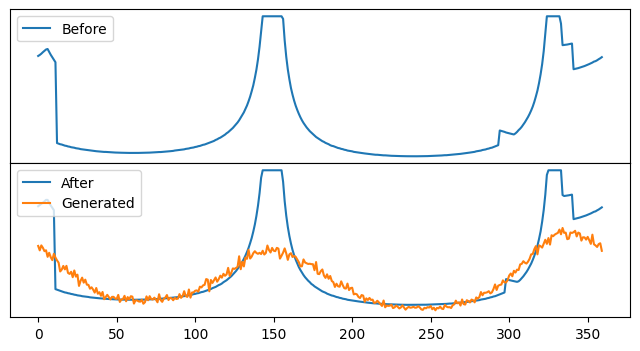

64/64 [==============================] - 34s 255ms/step - Gen_total_loss: 7.2763 - Disc_loss: 1.4661 - Reality_loss: 0.7131 - L1 loss: 0.0656 - Weighted L1 Loss: 6.5632
Epoch 2/5
64/64 [==============================] - 6s 86ms/step - Gen_total_loss: 6.4456 - Disc_loss: 1.1586 - Reality_loss: 0.9952 - L1 loss: 0.0545 - Weighted L1 Loss: 5.4505
Epoch 3/5
64/64 [==============================] - 7s 104ms/step - Gen_total_loss: 6.0039 - Disc_loss: 1.0487 - Reality_loss: 1.0665 - L1 loss: 0.0494 - Weighted L1 Loss: 4.9373
Epoch 4/5
64/64 [==============================] - 6s 86ms/step - Gen_total_loss: 5.2108 - Disc_loss: 1.1002 - Reality_loss: 1.0060 - L1 loss: 0.0420 - Weighted L1 Loss: 4.2048
Epoch 5/5
64/64 [==============================] - 7s 103ms/step - Gen_total_loss: 4.8510 - Disc_loss: 1.1053 - Reality_loss: 0.9526 - L1 loss: 0.0390 - Weighted L1 Loss: 3.8984


In [9]:
cgan.fit(dataset, epochs =5,  callbacks = [monitor])

# Analysis

Comparing with True Labels

Action: Straight, Turn Angle: 0.0, Velocity: 1.0
Deviation: 0.02793670818209648


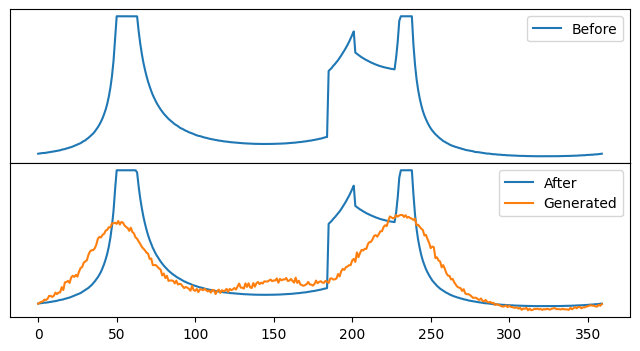

In [10]:
for x,y in dataset.take(1): cgan.visual_inspection(x,y)

 Sampling a random observation for seed (Initial Observation)

In [11]:
shuf = dataset.shuffle(buffer_size=10).take(1)
for x,_ in shuf: observation =x [0]

Custom Action Command

Action: Left, Turn Angle: 0.5833333333333334, Velocity: 1.0


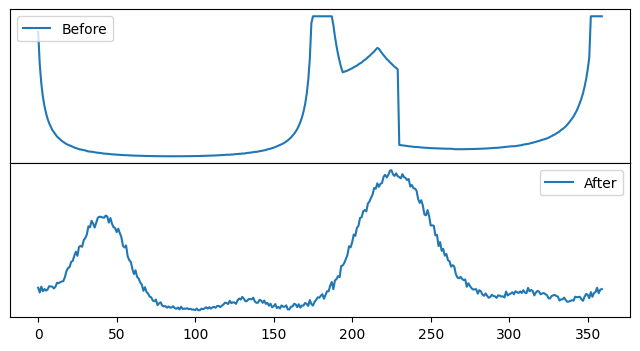

In [12]:
turn_angle = 35
velocity = 1.0
cgan.execute(observation,turn_angle/60,velocity)

In Loop

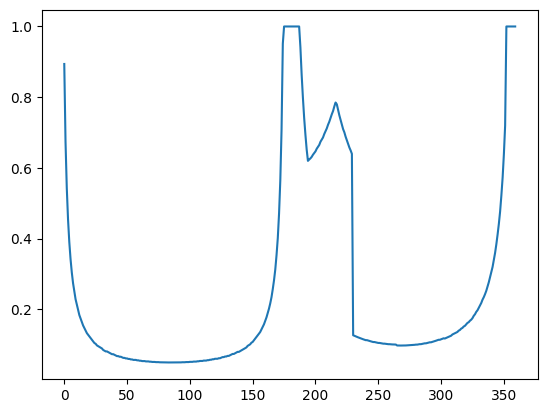

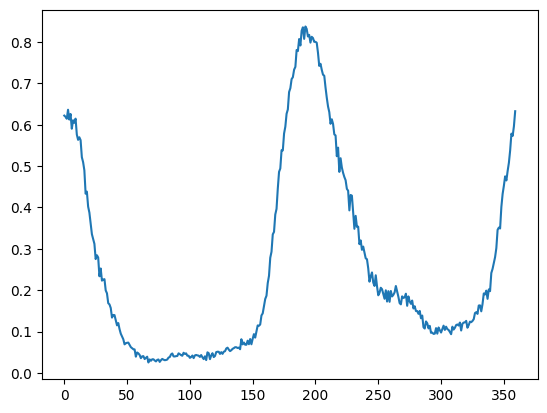

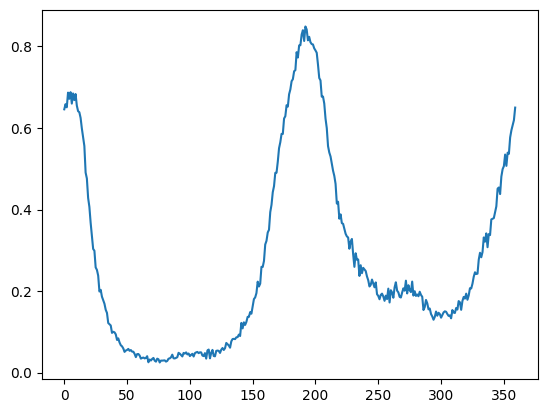

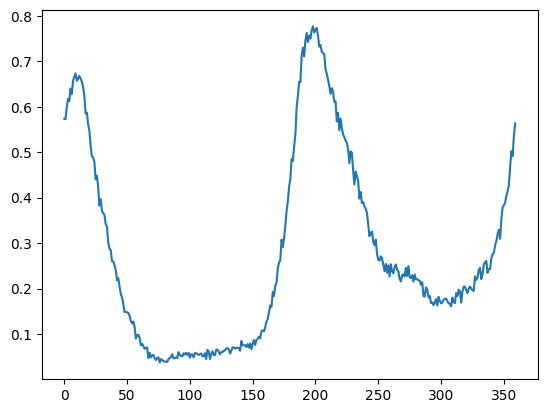

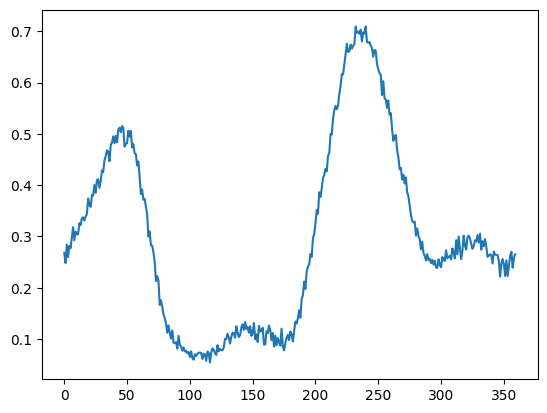

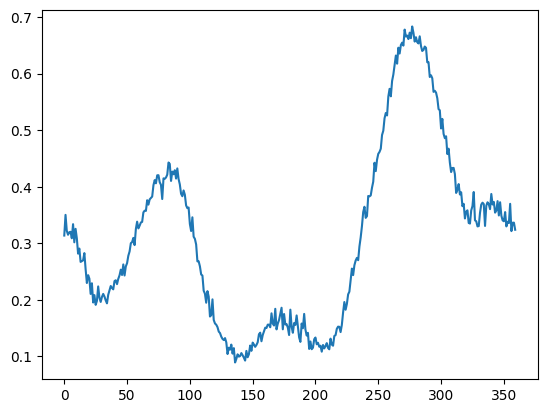

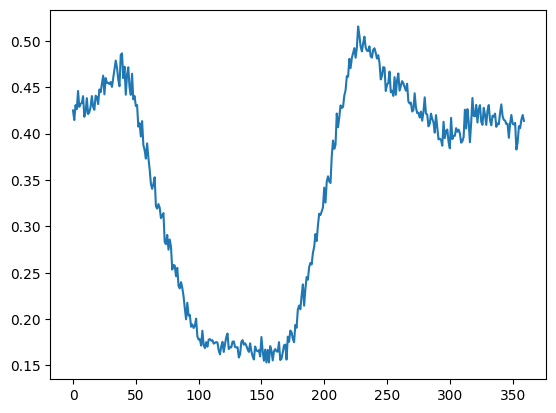

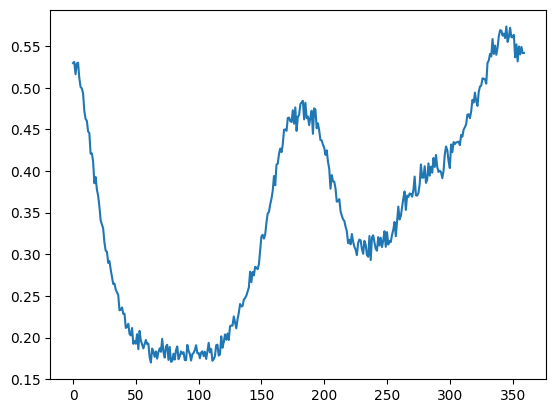

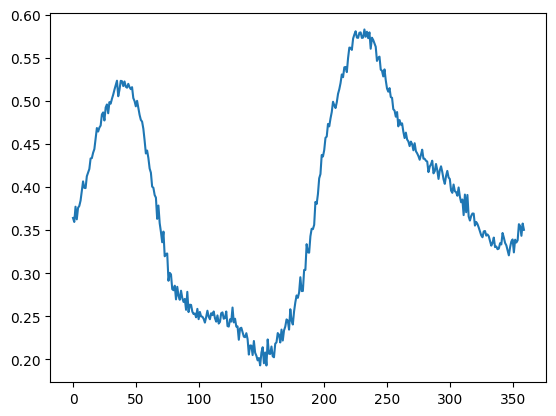

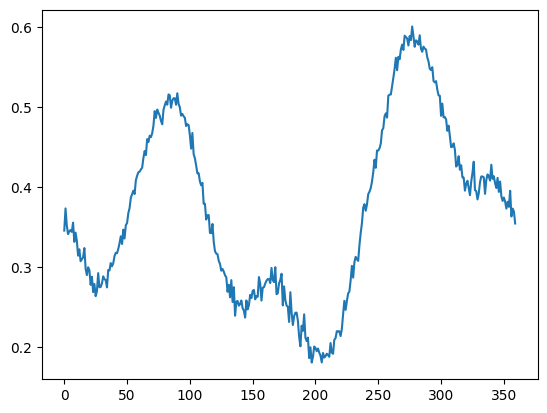

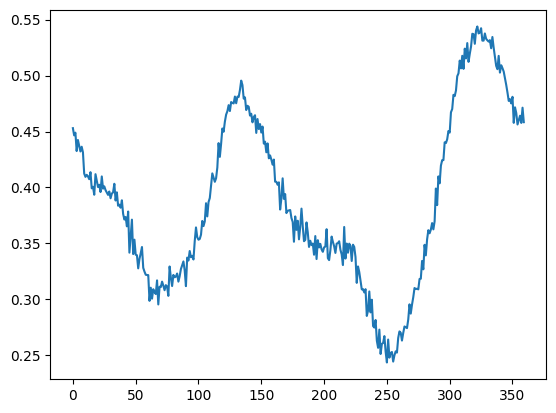

In [13]:
plt.plot(list(observation)[:-3])
plt.show()
for _ in range (10):
  turn_angle = np.random.uniform(-1, 1)
  velocity = np.random.uniform(-1, 1)
  action = 0.
  if turn_angle>0: action = 1.
  elif turn_angle<0: action = 2.
  inp = np.array(list(observation)[:360]+[action,turn_angle,velocity])
  inp = inp.reshape(1,363)
  pred = cgan.generator(inp)
  pred = pred.numpy().reshape(360,)
  observation = pred
  plt.plot(list(observation))
  plt.show()

# Saving Models

In [16]:
cgan.generator.save(f"{path_to_model}Generator.h5")
cgan.discriminator.save(f"{path_to_model}/Discriminator.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
